<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S11/Session_11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 - Creating Curves

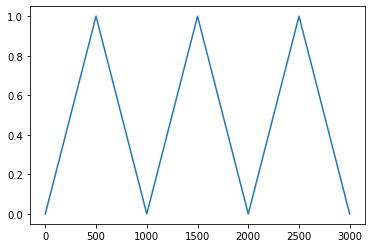

In [0]:
# General Method
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 500)
x = np.concatenate((x, x[::-1],x, x[::-1],x, x[::-1]), axis=None)
y = np.arange(len(x))
plt.plot(y, x)
plt.show()

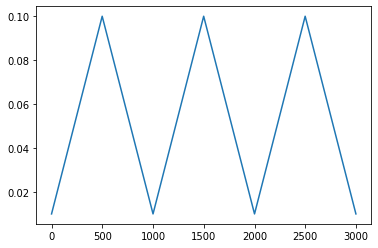

In [0]:
# Method of OneCycleLR
def annealing_linear(start, end, pct):
  return (end - start) * pct + start

steps = 1000
up = float(0.5*steps) - 1
down = float(steps - up) - 1

y = [annealing_linear(0.01, 0.1, x/up) if x<=up else annealing_linear(0.1, 0.01, (x-up)/down) for x in range(steps)] * 3
x = list(range(len(y)))
plt.plot(x,y)
plt.show()

# Import Libraries

In [0]:
!git clone https://github.com/sridevibonthu/EVALibrary.git
import sys
sys.path.append("/content/EVALibrary/EVA4")

Cloning into 'EVALibrary'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 53 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


# Installation of Latest Albumentations Library

In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1dv0ylnw
All libraries are successfully installed!


In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A
from torchvision import transforms

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                      A.PadIfNeeded(min_height=40, min_width=40),
                                      A.RandomCrop(32,32),
                                       #A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       #A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8, max_w_size=8) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders
batch_size=512

dataloader = eva4dataloaders.DataLoader(batch_size=batch_size)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([512, 3, 32, 32])
torch.Size([512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


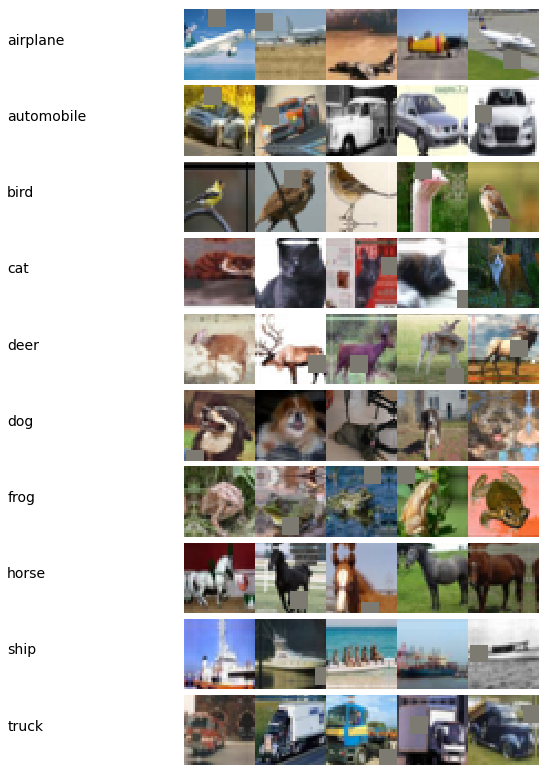

In [0]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Creation

We will be calling Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4 library.

In [0]:
from eva4models.S11Model import newResnetS11
import torch
model = newResnetS11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [0]:
model

newResnetS11(
  (prepLayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1Conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer1resnetBlock1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer2Conv1): Sequen

## LR Range Test

Epochs -  10
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


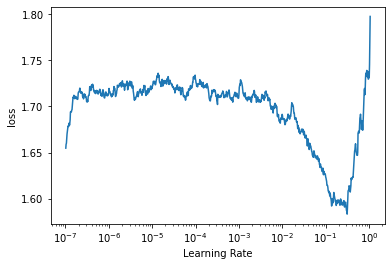

0.31203836956604647


In [0]:
from EVALRRangeFinder import LRRangeFinder 
lrfinder = LRRangeFinder(model=model, epochs=10, start_lr=1e-7, end_lr=1.0, dataloader=train_loader, trainlen=len(train), batch_size=batch_size)
max_lr = lrfinder.findLR()
print(max_lr)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
model = newResnetS11()    #Model reinstantiation
model.to(model.device)

batch_size=512
import torch.optim as optim
L1lambda = 0
L2lambda = 1e-4
EPOCHS = 24
optimizer = optim.SGD(model.parameters(), lr=max_lr/10, momentum=0.9, nesterov=True, weight_decay=L2lambda)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=int(len(train)/batch_size)+1, epochs=EPOCHS,  anneal_strategy='linear', pct_start=0.2, div_factor=10, final_div_factor=1 )
print("Initial LR- ",scheduler.get_lr())
print("Total steps - ", scheduler.total_steps)
print("No.of steps to increase LR -", scheduler.step_size_up)
print("No.of steps to reduce LR - ", scheduler.step_size_down)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, True,L1lambda)

Initial LR-  [0.03120383695660465]
Total steps -  2352
No.of steps to increase LR - 469.40000000000003
No.of steps to reduce LR -  1881.6



Validation loss decreased (100000.000000 --> 1.274804).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0028, Accuracy: 49.09%; Test set: Average loss: 1.2748, Accuracy: 55.09%
Learning Rate = 0.089836



Validation loss decreased (1.274804 --> 0.952296).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0021, Accuracy: 62.75%; Test set: Average loss: 0.9523, Accuracy: 67.26%
Learning Rate = 0.148468



Validation loss decreased (0.952296 --> 0.724711).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0016, Accuracy: 70.80%; Test set: Average loss: 0.7247, Accuracy: 75.56%
Learning Rate = 0.207099



Epoch: 4, Train set: Average loss: 0.0014, Accuracy: 76.07%; Test set: Average loss: 0.7720, Accuracy: 74.48%
Learning Rate = 0.265731



Validation loss decreased (0.724711 --> 0.644672).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0012, Accuracy: 78.69%; Test set: Average loss: 0.6447, Accuracy: 78.55%
Learning Rate = 0.308964



Validation loss decreased (0.644672 --> 0.605834).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0010, Accuracy: 81.63%; Test set: Average loss: 0.6058, Accuracy: 79.60%
Learning Rate = 0.294337



Validation loss decreased (0.605834 --> 0.577113).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0009, Accuracy: 83.78%; Test set: Average loss: 0.5771, Accuracy: 79.96%
Learning Rate = 0.279710



Validation loss decreased (0.577113 --> 0.560366).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0008, Accuracy: 85.65%; Test set: Average loss: 0.5604, Accuracy: 81.25%
Learning Rate = 0.265083



Validation loss decreased (0.560366 --> 0.482427).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0007, Accuracy: 86.71%; Test set: Average loss: 0.4824, Accuracy: 84.00%
Learning Rate = 0.250457



Validation loss decreased (0.482427 --> 0.428208).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0007, Accuracy: 87.84%; Test set: Average loss: 0.4282, Accuracy: 85.53%
Learning Rate = 0.235830



Epoch: 11, Train set: Average loss: 0.0006, Accuracy: 88.72%; Test set: Average loss: 0.4532, Accuracy: 85.20%
Learning Rate = 0.221203



Validation loss decreased (0.428208 --> 0.410625).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0006, Accuracy: 89.60%; Test set: Average loss: 0.4106, Accuracy: 86.44%
Learning Rate = 0.206576



Validation loss decreased (0.410625 --> 0.376728).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0005, Accuracy: 90.54%; Test set: Average loss: 0.3767, Accuracy: 87.67%
Learning Rate = 0.191949



Epoch: 14, Train set: Average loss: 0.0005, Accuracy: 91.20%; Test set: Average loss: 0.3943, Accuracy: 87.56%
Learning Rate = 0.177323



Validation loss decreased (0.376728 --> 0.354308).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 91.96%; Test set: Average loss: 0.3543, Accuracy: 88.76%
Learning Rate = 0.162696



Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 92.48%; Test set: Average loss: 0.3783, Accuracy: 88.38%
Learning Rate = 0.148069



Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 92.95%; Test set: Average loss: 0.3739, Accuracy: 88.74%
Learning Rate = 0.133442



Validation loss decreased (0.354308 --> 0.342359).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0003, Accuracy: 93.72%; Test set: Average loss: 0.3424, Accuracy: 89.29%
Learning Rate = 0.118815



Epoch: 19, Train set: Average loss: 0.0003, Accuracy: 94.29%; Test set: Average loss: 0.3649, Accuracy: 88.76%
Learning Rate = 0.104189



Epoch: 20, Train set: Average loss: 0.0003, Accuracy: 94.71%; Test set: Average loss: 0.3605, Accuracy: 89.30%
Learning Rate = 0.089562



Validation loss decreased (0.342359 --> 0.321740).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0003, Accuracy: 95.31%; Test set: Average loss: 0.3217, Accuracy: 90.57%
Learning Rate = 0.074935



Epoch: 22, Train set: Average loss: 0.0002, Accuracy: 95.94%; Test set: Average loss: 0.3348, Accuracy: 90.71%
Learning Rate = 0.060308



Epoch: 23, Train set: Average loss: 0.0002, Accuracy: 96.50%; Test set: Average loss: 0.3237, Accuracy: 90.63%
Learning Rate = 0.045681



Epoch: 24, Train set: Average loss: 0.0002, Accuracy: 97.09%; Test set: Average loss: 0.3298, Accuracy: 90.51%
Learning Rate = 0.031055



In [0]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.97088
0.9071


In [0]:
# Learning Rate Vs Iterations (One Cycle Policy)

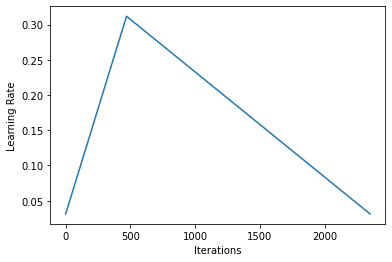

In [0]:
import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.plot(model.stats().batch_lr)
plt.xticks(np.arange(0, len(model.stats().batch_lr), step=500))
plt.show()

# Accuracy curves

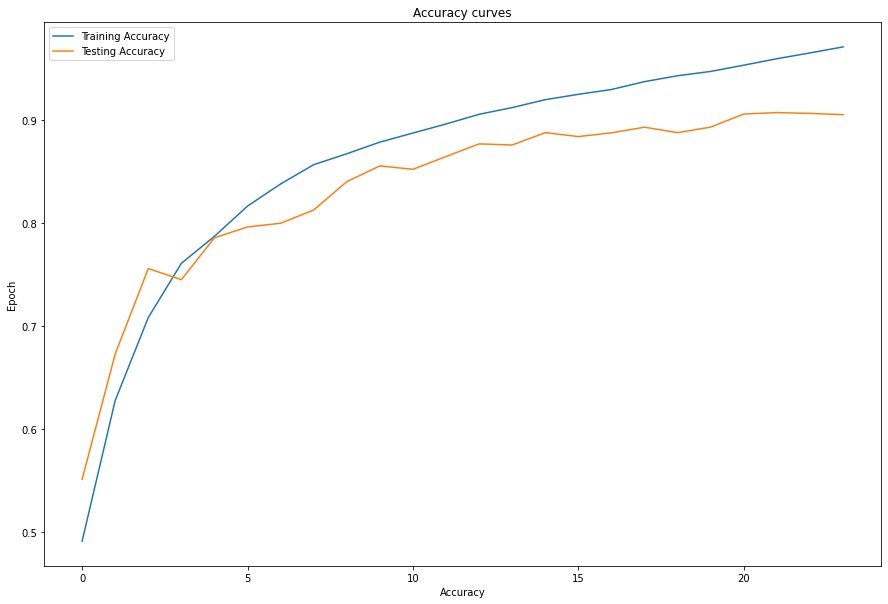

In [0]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

# Misclassified images

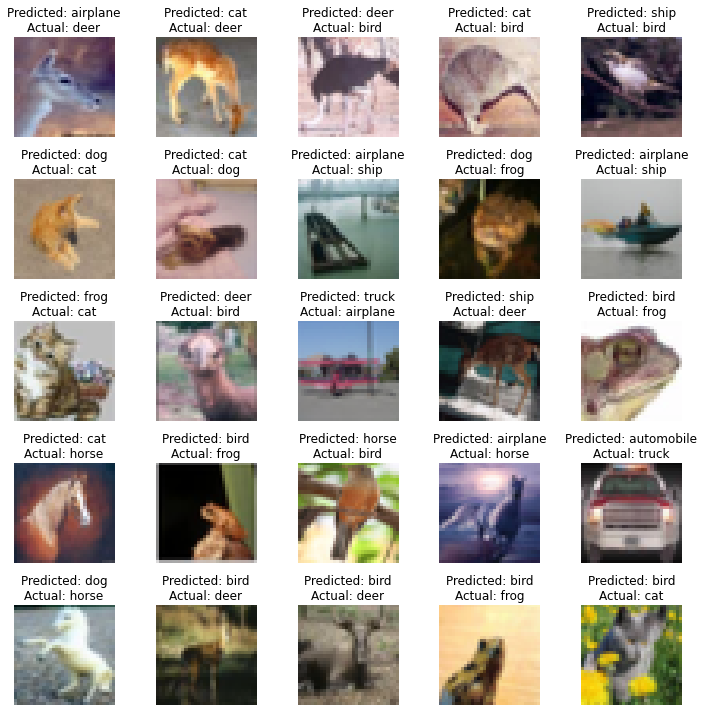

In [0]:

import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))
